In [19]:
# 파일읽기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import rc
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

In [20]:
adf = adfuller(df['평균기온'])
print(f'ADF 통계: {adf[0]}')
print(f'p값: {adf[1]}')

ADF 통계: -16.619186130070013
p값: 1.7040000780816676e-29


In [21]:
# EDA
df.shape #(23011,11)
df.info()
df.describe()
#Null Count
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      23011 non-null  object 
 1   최고기온    23008 non-null  float64
 2   최저기온    23008 non-null  float64
 3   일교차     23007 non-null  float64
 4   강수량     9150 non-null   float64
 5   평균습도    23011 non-null  float64
 6   평균풍속    23007 non-null  float64
 7   일조합     22893 non-null  float64
 8   일사합     18149 non-null  float64
 9   일조율     22645 non-null  float64
 10  평균기온    23011 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

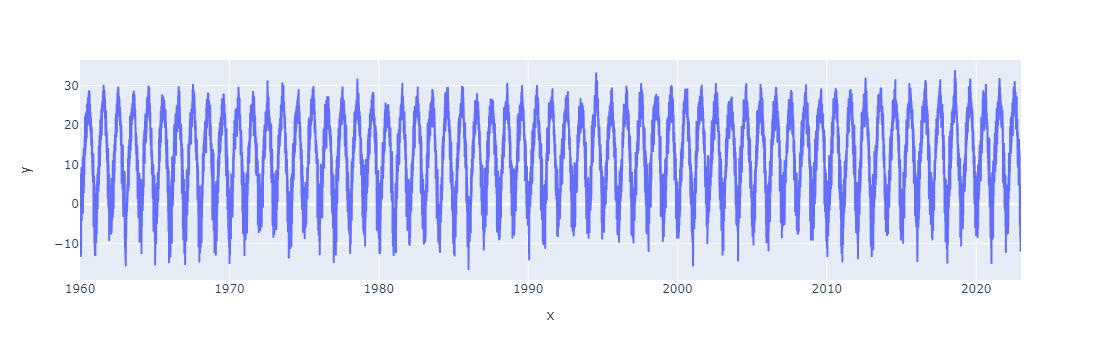

In [22]:
# 현재까지의 기온 변화
fig = px.line(x=df.일시, y=df.평균기온)
fig.show()

In [23]:
# 1 Preprocessing
df[['최고기온','최저기온','일교차','평균풍속','일조합','일사합','일조율']] =  df[['최고기온','최저기온','일교차','평균풍속','일조합','일사합','일조율']].fillna(method='bfill')
df['강수량'] = df['강수량'].fillna(0)
df.isnull().sum()

# Fake Test Slice
# train : 20180101~ test : 2022
train = df.iloc[21185:].reset_index()
test = df.iloc[22646:]
test = test.iloc[:358].reset_index()
test['일시'] = sample['일시']
test_일시 = test.pop('일시')

In [24]:
train = train.drop(['index','일시'],axis=1)
test = test.drop(['index','평균기온'],axis=1)
y = train.pop('평균기온')

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   최고기온    1826 non-null   float64
 1   최저기온    1826 non-null   float64
 2   일교차     1826 non-null   float64
 3   강수량     1826 non-null   float64
 4   평균습도    1826 non-null   float64
 5   평균풍속    1826 non-null   float64
 6   일조합     1826 non-null   float64
 7   일사합     1826 non-null   float64
 8   일조율     1826 non-null   float64
dtypes: float64(9)
memory usage: 128.5 KB


In [26]:
# 2 Encoding & Scaling
# from sklearn.preprocessing import LabelEncoder
# 범주형(object)가 이전 과정에서 제거됨.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(train)
scaler.fit_transform(test)

# 3 train test split
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(train, y, test_size = 0.3)

In [27]:
# 4 RandomForestRegressor, ExtraTreesRegressor, XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error

def score(a, b):
    return mean_absolute_error(a, b)
# 4.1 RandomForestRegressor
rf = RandomForestRegressor(random_state=0, max_depth=10, n_estimators=500)
rf.fit(x_tr,y_tr)
pred_rf = rf.predict(x_val)
print('RF MAE :', score(y_val, pred_rf))

# 4-2. XGBRegressor
xgb= XGBRegressor(random_state=0)
xgb.fit(x_tr,y_tr)
pred_xgb = xgb.predict(x_val)
print('XGB MAE :', score(y_val,pred_xgb))

# 4-3. ExtraTreesRegressor
et = ExtraTreesRegressor(random_state=0, max_depth=10, n_estimators=500)
et.fit(x_tr, y_tr)
pred_et = et.predict(x_val)
print('ET MAE :', score(y_val, pred_et))

RF MAE : 0.42965094327980874
XGB MAE : 0.49002394536714056
ET MAE : 0.39008332488318864


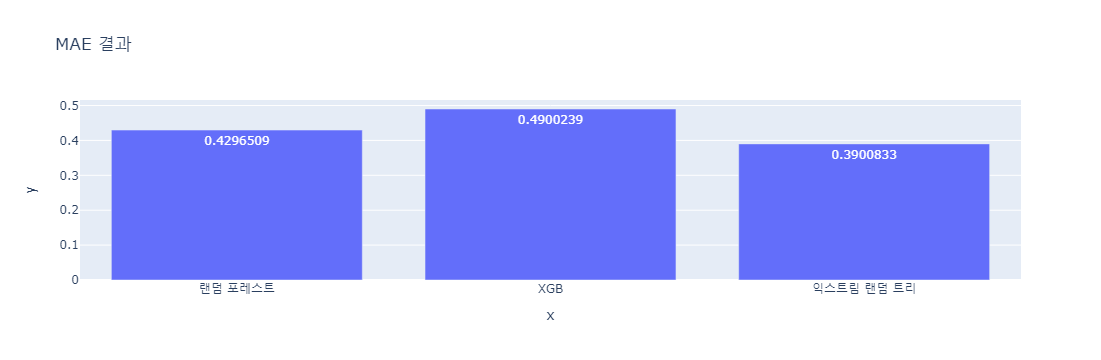

In [28]:
# MAE 시각화
import plotly.express as px
models = ['랜덤 포레스트', 'XGB', '익스트림 랜덤 트리']
mae = [score(y_val, pred_rf), score(y_val,pred_xgb), score(y_val, pred_et)]
viz = pd.DataFrame({'model':models, 'MAE': mae})
fig = px.bar(x=viz.model, y=viz.MAE, title = 'MAE 결과')
fig.update_traces(texttemplate='%{y}', textposition="inside")
fig.show()

In [30]:
display(test)

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율
0,2.3,-10.2,12.5,0.0,46.3,1.5,9.0,10.39,93.8
1,3.0,-5.2,8.2,0.3,57.9,2.3,5.4,8.52,56.3
2,2.5,-8.0,10.5,0.0,58.3,1.8,7.8,9.35,80.4
3,1.0,-5.6,6.6,0.0,51.8,2.4,9.0,11.30,92.8
4,1.9,-7.8,9.7,0.0,47.6,1.7,1.9,6.12,19.6
...,...,...,...,...,...,...,...,...,...
353,2.9,-9.5,12.4,0.0,55.8,2.2,7.7,10.10,80.2
354,2.6,-2.6,5.2,3.6,82.4,2.7,0.0,2.48,0.0
355,-2.6,-11.3,8.7,0.0,60.5,4.4,7.4,10.05,77.1
356,-8.6,-13.7,5.1,0.0,60.5,4.3,8.4,10.76,87.5


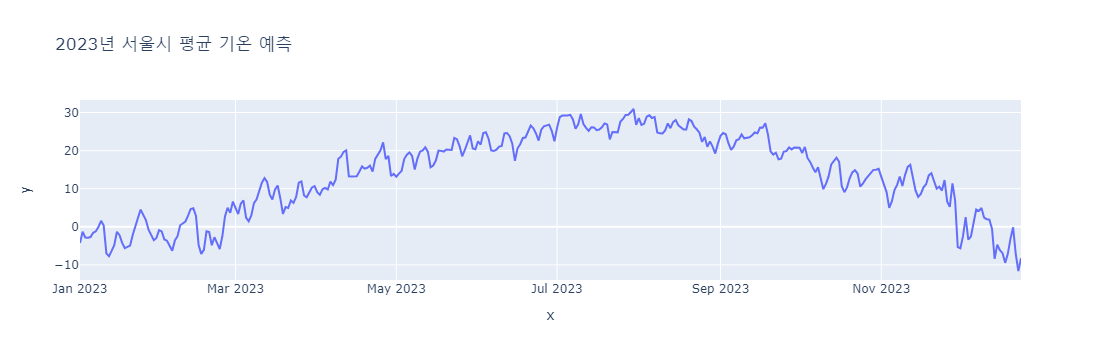

In [35]:
pred = et.predict(test)
pd.DataFrame({'일시': test_일시, '평균기온':pred}).to_csv('서울시 평균 기온 예측.csv', index=False)
result = pd.read_csv('서울시 평균 기온 예측.csv')

#결과 시각화
px.line(x = result.일시, y = result.평균기온, title = '2023년 서울시 평균 기온 예측')

In [36]:
result

,일시,평균기온
0,2023-01-01,-4.260398
1,2023-01-02,-1.277795
2,2023-01-03,-2.802993
3,2023-01-04,-2.837959
4,2023-01-05,-2.672994
...,...,...
353,2023-12-20,-3.151300
354,2023-12-21,-0.109190
355,2023-12-22,-7.084531
356,2023-12-23,-11.592700
